## Directory

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

## Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Acquire Data

In [5]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 [==============================] - 19s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
CPU times: user 2.3 s, sys: 3.27 s, total: 5.57 s
Wall time: 19.2 s


### Visualization

Displaying frames for example 825.


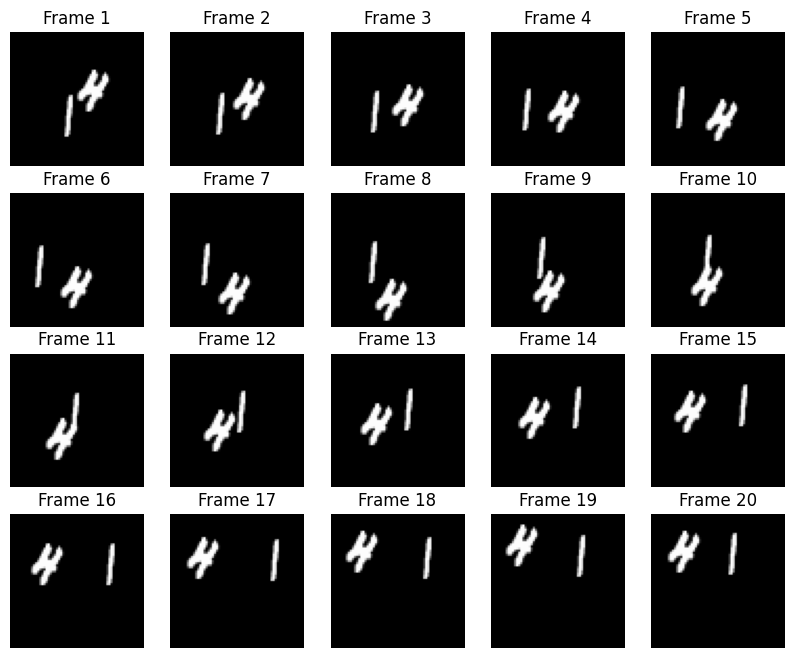

CPU times: user 1.23 s, sys: 251 ms, total: 1.48 s
Wall time: 1.25 s


In [ ]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_image_sequences(x_train, y_train, num_samples=5):
    """
    Plots sequences of input and output images for a number of samples, with titles.

    Args:
    x_train (np.ndarray): Input image sequences.
    y_train (np.ndarray): Output image sequences.
    num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 38, figsize=(38, num_samples * 2))  # Adjusted figsize for title space
    fig.suptitle("Sample Input/Output Sequence Images from Moving MNIST", fontsize=25, y=1.05)
    plt.figtext(0.5, 1.01, "First 19 frames are input sequences whereas latter 19 frames are output sequences",
                ha='center', fontsize=25, va='top')

    for i in range(num_samples):
        for j in range(19):  # Plot input images
            axes[i, j].imshow(x_train[i, j, :, :, 0], cmap='gray')
            axes[i, j].set_title(f'Frame {j + 1}', fontsize=8)
            axes[i, j].axis('off')
        for j in range(19):  # Plot output images
            axes[i, j + 19].imshow(y_train[i, j, :, :, 0], cmap='gray')
            axes[i, j + 19].set_title(f'Frame {j + 20}', fontsize=8)
            axes[i, j + 19].axis('off')

    plt.tight_layout()
    plt.show()

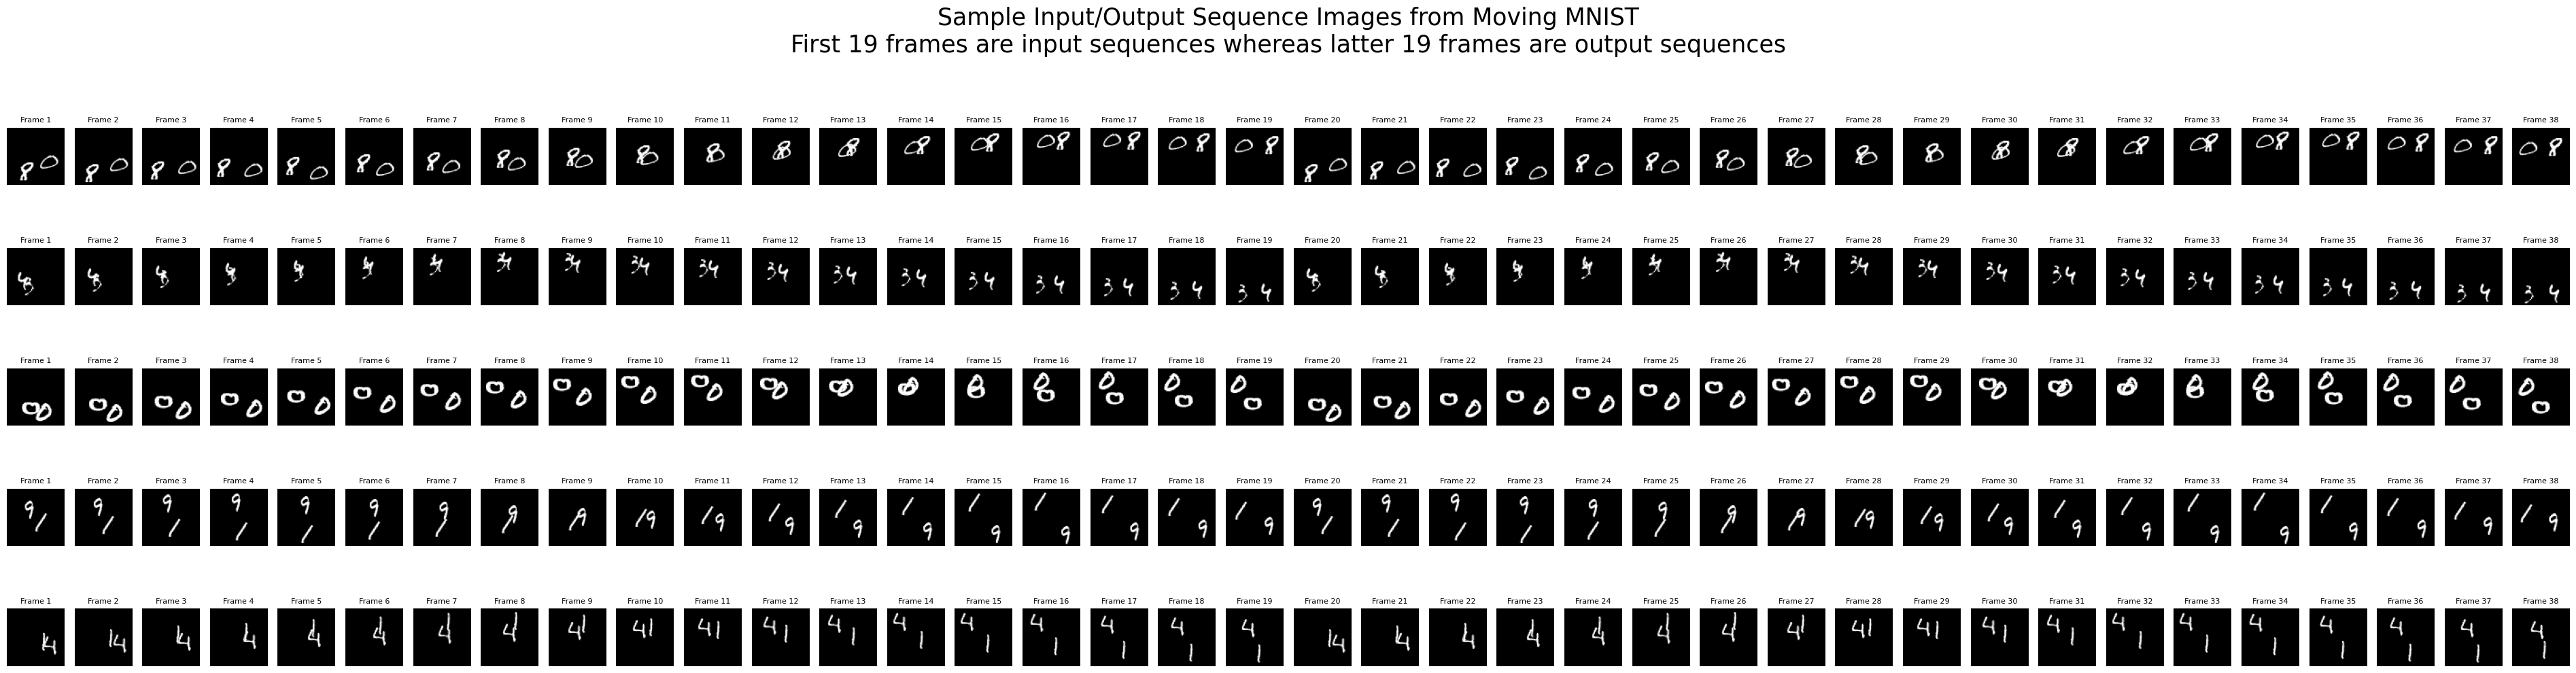

CPU times: user 12.2 s, sys: 403 ms, total: 12.6 s
Wall time: 12.2 s


In [ ]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

## Build `VAPAAD` Model

In [104]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

from typing import Tuple


class SelfAttention(layers.Layer):
    """
    A custom self-attention layer that computes attention scores to enhance model performance by focusing on relevant parts of the input data.

    This layer creates query, key, and value representations of the input, then calculates attention scores to determine how much focus to put on each part of the input data. The output is a combination of the input and the attention mechanism's weighted focus, which allows the model to pay more attention to certain parts of the data.

    Attributes:
        query_dense (keras.layers.Dense): A dense layer for transforming the input into a query tensor.
        key_dense (keras.layers.Dense): A dense layer for transforming the input into a key tensor.
        value_dense (keras.layers.Dense): A dense layer for transforming the input into a value tensor.
        combine_heads (keras.layers.Dense): A dense layer for combining the attention heads' outputs.
    """

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape: Tuple[int, ...]):
        """
        Initializes the internal dense layers based on the last dimension of the input shape, setting up the query, key, value, and combine heads layers.

        Args:
            input_shape (Tuple[int, ...]): The shape of the input tensor to the layer.
        """
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Performs the self-attention mechanism on the input tensor and returns the combined output with a residual connection.

        Args:
            inputs (tf.Tensor): The input tensor to the self-attention layer.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and combining with the input tensor through a residual connection.
        """
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output


class VAPAAD:
    """ A class to handle video processing with data augmentation and self-attention mechanisms. """
    def __init__(self, input_shape: Tuple[int, int, int]):
        self.input_shape = input_shape
        # Initialize generator and instructor models
        self.gen_main = self.build_generator()
        self.gen_aux = self.build_generator()
        self.instructor = self.build_instructor()
        # Define loss functions and optimizers
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.instructor_optimizer = tf.keras.optimizers.Adam(1e-4)

    def build_generator(self):
        """
        Builds a video processing model with data augmentation and self-attention mechanisms.

        Args:
            input_shape (Tuple[int, int, int]): The shape of the input frames.

        Returns:
            keras.Model: A compiled keras model ready for training.
        """
        # Define a ConvLSTM model with self-attention for the generator
        data_augmentation = keras.Sequential([
            layers.RandomZoom(height_factor=0.05, width_factor=0.05),
            layers.RandomRotation(factor=0.02),
            layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
        ], name="data_augmentation")

        # Input and convolutional layers with self-attention
        inp = layers.Input(shape=self.input_shape)
        x = layers.TimeDistributed(data_augmentation)(inp)
        x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = SelfAttention()(x)
        x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)
        return keras.models.Model(inputs=inp, outputs=x)

    def build_instructor(self):
        """
        Builds a video processing model ending with fully connected layers.

        Args:
            input_shape (Tuple[int, int, int]): The shape of the input frames.

        Returns:
            keras.Model: A compiled keras model ready for training with a one-dimensional output.
        """
        # Define a model with fully connected layers as the instructor
        inp = layers.Input(shape=self.input_shape)
        x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(inp)
        x = layers.BatchNormalization()(x)
        x = SelfAttention()(x)
        x = layers.GlobalAveragePooling3D()(x)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dense(512, activation='relu')(x)
        output = layers.Dense(1, activation='sigmoid')(x)
        return keras.models.Model(inputs=inp, outputs=output)

    def train_step(self, images, future_images):
        """
        Perform a single training step by updating the generator and instructor models.

        Args:
            images (tf.Tensor): Input images for the generator model `gen_main`.
            future_images (tf.Tensor): Future images for the generator model `gen_aux`.
            gen_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the generator model.
            inst_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the instructor model.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: Tuple containing the generator loss and instructor loss.
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as inst_tape:
            # Generate outputs for both current and future inputs
            output_main = self.gen_main(images, training=True)
            output_aux = self.gen_aux(future_images, training=True)
            real_output = self.instructor(output_aux, training=True)
            fake_output = self.instructor(output_main, training=True)
            # Calculate losses for both models
            gen_loss = self.generator_loss(fake_output)
            inst_loss = self.instructor_loss(real_output, fake_output)

        # Apply gradients to update model weights
        gradients_of_gen = gen_tape.gradient(gen_loss, self.gen_main.trainable_variables)
        gradients_of_inst = inst_tape.gradient(inst_loss, self.instructor.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_gen, self.gen_main.trainable_variables))
        self.instructor_optimizer.apply_gradients(zip(gradients_of_inst, self.instructor.trainable_variables))
        return gen_loss, inst_loss

    def generator_loss(self, fake_output):
        """
        Calculates the loss for the generator model based on its output for generated (fake) images.

        The loss encourages the generator to produce images that the instructor model classifies as real.
        This is achieved by comparing the generator's output for fake images against a target tensor of ones,
        indicating that the ideal output of the generator would be classified as real by the instructor model.

        Args:
        fake_output (tf.Tensor): The generator model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The loss for the generator model, encouraging it to generate more realistic images.
        """
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def instructor_loss(self, real_output, fake_output):
        """
        Calculates the loss for the instructor model based on its output for real and generated (fake) images.

        The loss is computed as the sum of the cross-entropy losses for the real and fake outputs. For real images,
        the target is a tensor of ones, and for fake images, the target is a tensor of zeros.

        Args:
        real_output (tf.Tensor): The instructor model's output logits for real images.
        fake_output (tf.Tensor): The instructor model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The total loss for the instructor model, combining the real and fake loss components.
        """
        # Define real_loss and fake_loss
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def train(self, x_train, y_train, batch_size=64):
        """
        Trains the model for a specified batch size.

        This function iterates over the entire dataset for a epoch,
        randomly selecting batches of data to perform training steps. The selection is random
        and without replacement within each epoch, ensuring diverse exposure of data.

        Args:
        x_train (np.ndarray): The input training data.
        y_train (np.ndarray): The target training data.
        batch_size (int, optional): The number of samples per batch of computation. Defaults to 64.

        Returns:
        None
        """
        n_samples = x_train.shape[0]
        start = time.time()
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for i in range(0, n_samples, batch_size):
            if i + batch_size > n_samples:
                continue  # Avoid index error on the last batch if it's smaller than the batch size
            selected_indices = indices[i:i + batch_size]
            x_batch = x_train[selected_indices]
            y_batch = y_train[selected_indices]
            curr_gen_loss, curr_inst_loss = self.train_step(x_batch, y_batch)
            if curr_gen_loss < 0.2:  # Early stopping condition
                print(f"Stopping early at epoch {i + 1}")
                return

            print(f'> running: current sample {i + 1}, gen_loss={curr_gen_loss}, inst_loss={curr_inst_loss}, time={time.time() - start} sec')


## Get Ready for Training

In [105]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


### Convert to `16bit` data

In [106]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [107]:
# Check gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [92]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[382 434 352 662 258 341]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


## Define model: `VAPAAD`

In [153]:
# Initializing a new VAPAAD model
vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

### Train

In [330]:
%%time

# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

# Example usage:
BATCH_SIZE = 3
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
else:
    vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

[120 612 186 444  62  85]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7648389339447021, inst_loss=1.326151728630066, time=1.5961244106292725 sec
> running: current sample 4, gen_loss=0.8130151629447937, inst_loss=1.334946870803833, time=3.4582226276397705 sec
> running: current sample 7, gen_loss=0.7890393137931824, inst_loss=1.3393230438232422, time=5.025229454040527 sec
> running: current sample 10, gen_loss=0.7146410346031189, inst_loss=1.3610854148864746, time=6.55842661857605 sec
> running: current sample 13, gen_loss=0.750133752822876, inst_loss=1.3449275493621826, time=8.115602970123291 sec
> running: current sample 16, gen_loss=0.6865960955619812, inst_loss=1.4275321960449219, time=9.719149112701416 sec
> running: current sample 19, gen_loss=0.6527233719825745, inst_loss=1.376233458518982, time=11.250356674194336 sec
> running: current sample 22, gen_loss=0.6997383236885071, inst_loss=1.312504768371582, time=12.781661033630371 sec
> running: 

### Extract generator

In [331]:
# Assuming you have a method to get the trained generator
trained_generator = vapaad_model.gen_main

### Prediction Using Generator

In [332]:
%%time

# prediction on validation set
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        y_val_pred = trained_generator.predict(x_val)
else:
    y_val_pred = trained_generator.predict(x_val)

print("Shape of true y_val:", y_val.shape)
print("Shape of predicted y_val:", y_val_pred.shape)

4/4 [==============================] - 2s 478ms/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)
CPU times: user 302 ms, sys: 191 ms, total: 493 ms
Wall time: 2.15 s


## Visualization

In [333]:
import numpy as np

def rescale_and_discretize(image):
    """
    Rescales an image to the 0-1 range and discretizes the values into levels {0.1, 0.2, ..., 0.9}.

    Args:
    image (np.ndarray): The input image to be rescaled and discretized.

    Returns:
    np.ndarray: The rescaled and discretized image.
    """
    # Rescale image to 0-1 range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) if max_val > min_val else image

    # Discretize to nearest levels in {0.1, 0.2, ..., 0.9}
    Q = 32  # Number of levels
    discretized_image = np.round(normalized_image * Q) / (Q+1)  # Multiplies by 9, rounds, then divides by 10
    discretized_image = np.clip(discretized_image, 0.1, 0.9)  # Ensures values are within the specified levels

    return discretized_image

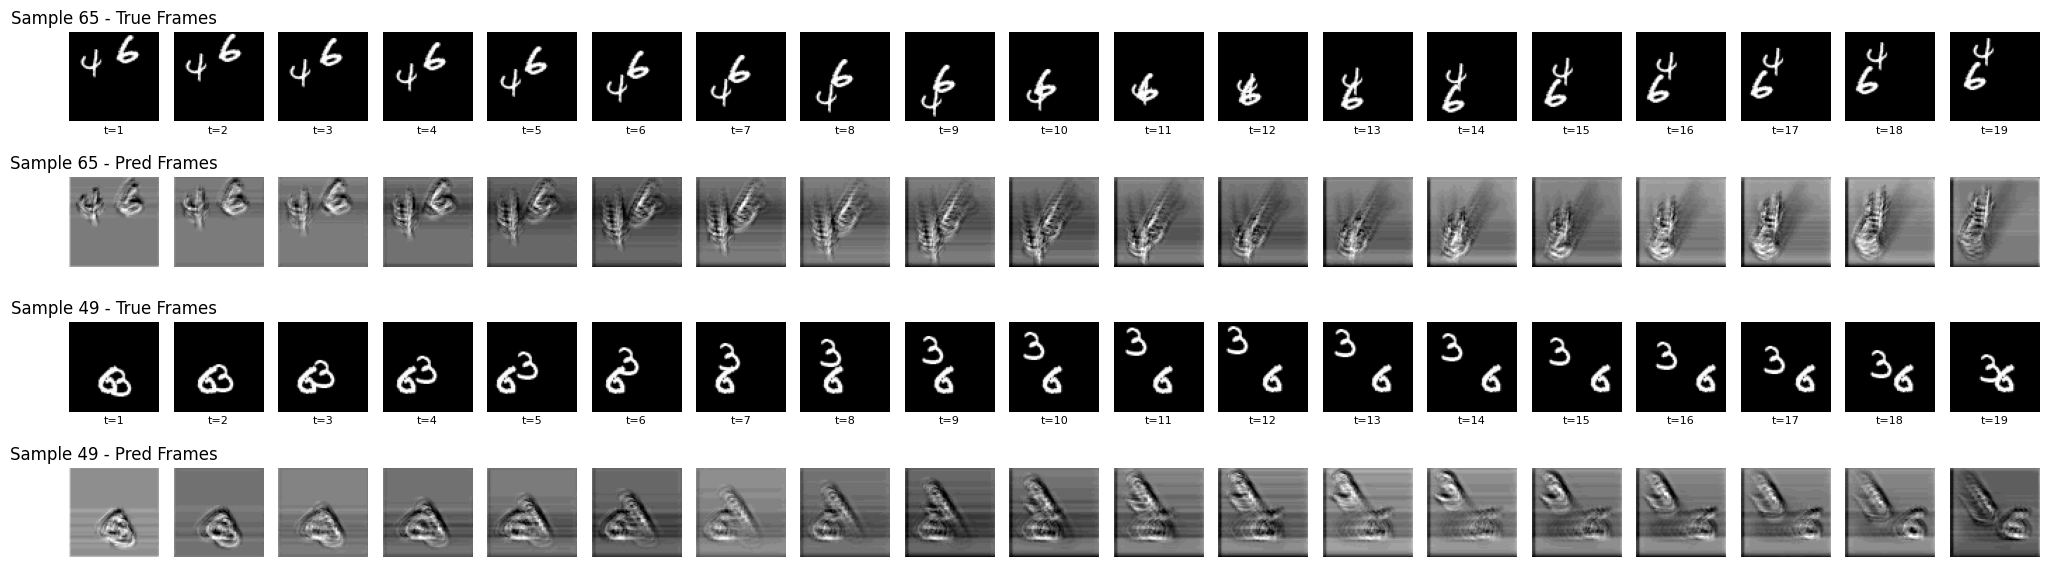

In [336]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

## Create `.gif`

In [335]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad_stop_grad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
        new_prediction = rescale_and_discretize(new_prediction)
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 0s 59ms/step
Truth	Prediction
